In [1]:
import pandas as pd
import numpy as np
import glob
import random
from io import BytesIO

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
# The images are in folders images_01, images_02, ...
# Retrieve path for each image
list_path = glob.glob("./images_**/*.png")

In [3]:
list_path[:3]

['./images_04/00009663_000.png',
 './images_04/00011140_017.png',
 './images_04/00010920_006.png']

In [4]:
# Extract name of files
files = [x.split('/')[-1] for x in list_path]

In [5]:
len(files)

107121

In [6]:
df_labels = pd.read_csv('Data_Entry_2017_v2020.csv')
df_labels.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [7]:
df_labels.shape

(112120, 11)

In [8]:
train_id = pd.read_table('train_val_list.txt', header=None)
test_id = pd.read_table('test_list.txt', header=None)

In [9]:
def define_data(list_path, files, df_labels, train_id, test_id):

    train_id['set'] = 'train'
    train_id.columns = ['image', 'set']
    
    test_id['set'] = 'test'
    test_id.columns = ['image', 'set']
    
    train_val_test_ids = pd.concat([train_id, test_id])
    
    df = df_labels[['Image Index', 'Finding Labels']]
    df['label'] = [1 if 'Pneumonia' in x.split('|') else 0 for x in df['Finding Labels']]
    df = df.drop(columns=['Finding Labels'])
    df.columns = ['image', 'label']
    
    df_paths = pd.DataFrame({'path': list_path, 'image': files})
    df = df.merge(df_paths, on='image', how='left')
    df = df.merge(train_val_test_ids, on='image', how='left')
    df = df.dropna()
    
    return df

In [10]:
df = define_data(list_path, files, df_labels, train_id, test_id)
df.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,image,label,path,set
4999,00001336_000.png,0,./images_01/00001336_000.png,train
5000,00001337_000.png,0,./images_01/00001337_000.png,train
5001,00001338_000.png,0,./images_01/00001338_000.png,train
5002,00001338_001.png,0,./images_01/00001338_001.png,train
5003,00001338_002.png,0,./images_01/00001338_002.png,train


In [11]:
train = df[df.set=='train']
test = df[df.set=='test']

In [12]:
X = train['path']
y = train['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.iloc[0]

'./images_04/00009679_000.png'

In [14]:
im = cv2.imread(X_train.iloc[0])

In [15]:
im.shape

(1024, 1024, 3)

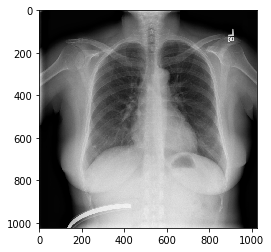

In [16]:
plt.imshow(im)

# Dataset

In [17]:
def preprocessing_steps(im, shape=(224, 224)):
    """
    Pre-process image. Reshape to model input shape and normalize the data with Imagenet stats.
    """
    im = cv2.resize(im, shape)
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    im =  (im - imagenet_stats[0])/imagenet_stats[1]
    return im

In [18]:
class ChestXRayDataset(Dataset):
 
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        im = cv2.imread(self.x.iloc[idx])
        im = preprocessing_steps(im)
        # Horizontal Flip
        if np.random.random() > 0.5: 
            im = np.fliplr(im).copy()
        return np.rollaxis(im, 2), self.y.iloc[idx]

In [19]:
train_ds = ChestXRayDataset(X_train, y_train)
valid_ds = ChestXRayDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=8)

In [20]:
x, y = next(iter(train_dl))

In [21]:
x.shape, y.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

# Model

In [22]:
resnet = models.resnet18(pretrained=True)

In [23]:
layers = list(resnet.children())
print(len(layers))

10


In [24]:
layers[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
    
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

# Learning rate finder

In [37]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [39]:
def LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=0.4, epochs=2):
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.float()
            y = y.float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y.unsqueeze(1))
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
    return lrs, losses

In [ ]:
model = Net()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1)

In [ ]:
plt.plot(lrs, losses)
plt.show()

# Training

In [ ]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [176]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
    
def load_model(m, p): 
    m.load_state_dict(torch.load(p))

In [ ]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        lr = lrs[idx]
        optimizer = get_optimizer(model, lr=lrs[idx])
        batch = y.shape[0]
        x = x.float()
        y = y.float()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total, idx

In [ ]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            path = "{0}/models/model_resnet34_{1:.0f}.pth".format(PATH, 100*val_acc)
            save_model(model, path)
            print(path)

In [ ]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            pred = (out > 0.0).long()
            correct += pred.eq(y.data).sum().item()
            y = y.float()
            loss = F.binary_cross_entropy_with_logits(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total, correct/total